In [7]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from fastapi import FastAPI, UploadFile, File
from fastapi.responses import JSONResponse
import streamlit as st
import requests
from PIL import Image

### Data Preprocessing

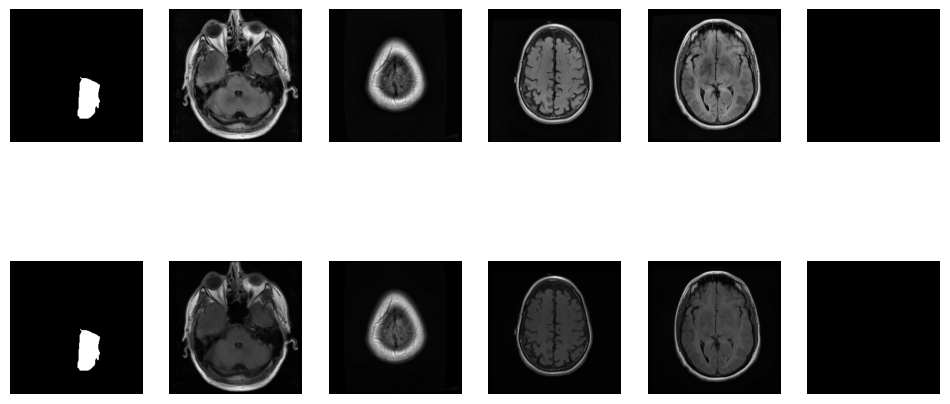

In [3]:
def load_data(image_dir, mask_dir):
    images = []
    masks = []
    
    # Iterate through subfolders in the image directory
    for subfolder in os.listdir(image_dir):
        subfolder_path = os.path.join(image_dir, subfolder)
        
        if os.path.isdir(subfolder_path):  # Check if it's a folder
            for img_name in os.listdir(subfolder_path):
                mask_name = img_name.replace('.jpg', '_mask.jpg')  # Adjust according to your mask naming convention
                img_path = os.path.join(subfolder_path, img_name)
                mask_path = os.path.join(mask_dir, subfolder, mask_name)  # Assuming masks are in a similar structure

                if os.path.exists(mask_path):
                    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

                    if img is not None and mask is not None:
                        images.append(img)
                        masks.append(mask)

    return np.array(images), np.array(masks)

def preprocess_images(images):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    processed_images = []

    for img in images:
        img = clahe.apply(img)
        img = img / 255.0  # Normalize
        processed_images.append(img)

    return np.array(processed_images)

# Load and preprocess data
images, masks = load_data('5C/Data', '5C/Data')
images = preprocess_images(images)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Optional: Visualize some examples
def visualize_examples(images, masks):
    plt.figure(figsize=(12, 6))
    for i in range(6):
        plt.subplot(2, 6, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
        plt.subplot(2, 6, i + 7)
        plt.imshow(masks[i], cmap='gray')
        plt.axis('off')
    plt.show()

visualize_examples(X_train, y_train)

### 2. Model Implementation

#### a. Nested U-Net (U-Net++)

In [4]:
def nested_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x1 = layers.Activation('relu')(x1)
    x2 = layers.Conv2D(32, (3, 3), padding='same')(x1)
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x2)
    model = models.Model(inputs, outputs)
    return model

unet_model = nested_unet((256, 256, 1))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### b. Attention U-Net

In [5]:
def attention_block(input_tensor, gating_tensor):
    theta_x = layers.Conv2D(32, (1, 1))(input_tensor)
    theta_g = layers.Conv2D(32, (1, 1))(gating_tensor)
    phi_g = layers.Conv2D(32, (1, 1))(gating_tensor)
    
    psi = layers.add([theta_x, theta_g])
    psi = layers.Activation('relu')(psi)
    psi = layers.Conv2D(1, (1, 1), activation='sigmoid')(psi)
    
    return layers.multiply([input_tensor, psi])

def attention_unet(input_shape):
    inputs = layers.Input(shape=input_shape)
    x1 = layers.Conv2D(32, (3, 3), padding='same')(inputs)
    x2 = attention_block(x1, x1) 
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x2)
    
    model = models.Model(inputs, outputs)
    return model

attention_model = attention_unet((256, 256, 1))
attention_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### 3. Model Training and Evaluation

In [ ]:
history_unet = unet_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=17, batch_size=16)
history_attention = attention_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=17, batch_size=16)

def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

dice_unet = dice_coefficient(y_test, unet_model.predict(X_test))
dice_attention = dice_coefficient(y_test, attention_model.predict(X_test))

Epoch 1/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 339s 861ms/step - accuracy: 0.5602 - loss: -185.9047 - val_accuracy: 0.5685 - val_loss: -185.2574
Epoch 2/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 329s 836ms/step - accuracy: 0.5599 - loss: -189.8755 - val_accuracy: 0.5688 - val_loss: -185.2710
Epoch 3/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 364s 927ms/step - accuracy: 0.5578 - loss: -190.2229 - val_accuracy: 0.5686 - val_loss: -185.2749
Epoch 4/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 328s 835ms/step - accuracy: 0.5595 - loss: -191.6350 - val_accuracy: 0.5690 - val_loss: -185.2776
Epoch 5/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 336s 855ms/step - accuracy: 0.5643 - loss: -187.2265 - val_accuracy: 0.5692 - val_loss: -185.2797
Epoch 6/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 386s 982ms/step - accuracy: 0.5619 - loss: -190.2971 - val_accuracy: 0.5691 - val_loss: -185.2803
Epoch 7/17
393/393 ━━━━━━━━━━━━━━━━━━━━ 312s 793ms/step - accuracy: 0.5640 - loss: -189.6708 - val_accuracy: 0.5689 - val_loss: -185.2821
Epoch 8/17
393/393 ━━━━━━━━━━━━━━━

### 4. Web Application Development

#### FAST API Backend

In [ ]:
app = FastAPI()

@app.post("/predict/")
async def predict(file: UploadFile = File(...)):
    image = await file.read()
    # Preprocess the image and predict using the best model
    processed_image = preprocess_image(image)  # Implement this function
    prediction = unet_model.predict(processed_image)
    return JSONResponse(content={"prediction": prediction.tolist()})

#### Streamlit Frontend

In [ ]:
st.title("Brain MRI Metastasis Segmentation")

uploaded_file = st.file_uploader("Choose a brain MRI image...", type="jpg")

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption='Uploaded Image.', use_column_width=True)
    
    if st.button("Predict"):
        response = requests.post("http://localhost:8000/predict/", files={"file": uploaded_file})
        st.write(response.json())